In [1]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, desc, sum as _sum, count, month, year
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


spark = SparkSession.builder.appName("Retail-Capstone").getOrCreate()

sc = spark.sparkContext

# Customers DataFrame
customers_data = [
    (1, "Rahul Sharma", "Bangalore", 28),
    (2, "Priya Singh", "Delhi", 32),
    (3, "Aman Kumar", "Hyderabad", 25),
    (4, "Sneha Reddy", "Chennai", 35),
    (5, "Arjun Mehta", "Mumbai", 30),
    (6, "Divya Nair", "Delhi", 29)
]
customers_cols = ["customer_id", "name", "city", "age"]
customers_df = spark.createDataFrame(customers_data, customers_cols)

# Products DataFrame
products_data = [
    (101, "Laptop", "Electronics", 55000),
    (102, "Mobile", "Electronics", 25000),
    (103, "Headphones", "Electronics", 3000),
    (104, "Chair", "Furniture", 5000),
    (105, "Book", "Stationery", 700),
    (106, "Shoes", "Fashion", 2500)
]
products_cols = ["product_id", "product_name", "category", "price"]
products_df = spark.createDataFrame(products_data, products_cols)

# Orders DataFrame
orders_data = [
    (1001, 1, 101, 1, "2024-01-10"),
    (1002, 2, 102, 2, "2024-01-12"),
    (1003, 1, 103, 3, "2024-02-05"),
    (1004, 3, 104, 1, "2024-02-08"),
    (1005, 5, 105, 5, "2024-03-01"),
    (1006, 6, 106, 2, "2024-03-15"),
    (1007, 7, 101, 1, "2024-03-20")
]
orders_cols = ["order_id", "customer_id", "product_id", "quantity", "order_date"]
orders_df = spark.createDataFrame(orders_data, orders_cols)

orders_df = orders_df.withColumn("order_date", col("order_date").cast("date"))

print("DataFrames created successfully!")
customers_df.show()
products_df.show()
orders_df.show()
orders_df.printSchema()

DataFrames created successfully!
+-----------+------------+---------+---+
|customer_id|        name|     city|age|
+-----------+------------+---------+---+
|          1|Rahul Sharma|Bangalore| 28|
|          2| Priya Singh|    Delhi| 32|
|          3|  Aman Kumar|Hyderabad| 25|
|          4| Sneha Reddy|  Chennai| 35|
|          5| Arjun Mehta|   Mumbai| 30|
|          6|  Divya Nair|    Delhi| 29|
+-----------+------------+---------+---+

+----------+------------+-----------+-----+
|product_id|product_name|   category|price|
+----------+------------+-----------+-----+
|       101|      Laptop|Electronics|55000|
|       102|      Mobile|Electronics|25000|
|       103|  Headphones|Electronics| 3000|
|       104|       Chair|  Furniture| 5000|
|       105|        Book| Stationery|  700|
|       106|       Shoes|    Fashion| 2500|
+----------+------------+-----------+-----+

+--------+-----------+----------+--------+----------+
|order_id|customer_id|product_id|quantity|order_date|
+------

In [2]:
# Convert a list of numbers into an RDD
numbers_list = [10, 20, 30, 40, 50]
numbers_rdd = sc.parallelize(numbers_list)

# Find sum, max, min, and average
rdd_sum = numbers_rdd.sum()
rdd_max = numbers_rdd.max()
rdd_min = numbers_rdd.min()
rdd_avg = numbers_rdd.mean()

print(f"RDD: {numbers_rdd.collect()}")
print(f"Sum: {rdd_sum}")
print(f"Max: {rdd_max}")
print(f"Min: {rdd_min}")
print(f"Average: {rdd_avg}")

RDD: [10, 20, 30, 40, 50]
Sum: 150
Max: 50
Min: 10
Average: 30.0


In [3]:
# Create an RDD of sentences
sentences_list = ["hello world", "spark is fun", "hello spark"]
sentences_rdd = sc.parallelize(sentences_list)

# Perform word count
word_counts = sentences_rdd.flatMap(lambda line: line.split(" ")) \
                           .map(lambda word: (word, 1)) \
                           .reduceByKey(lambda a, b: a + b)

print("Word Count Results:")
print(word_counts.collect())

Word Count Results:
[('hello', 2), ('world', 1), ('fun', 1), ('spark', 2), ('is', 1)]


In [4]:
print("Customer Names and Cities:")
customers_df.select("name", "city").show()

print("Customer Names and Cities:")
customers_df.select("name", "city").show()

print("Distinct product categories:")
products_df.select("category").distinct().show()

print("Top 3 most expensive products:")
products_df.orderBy(desc("price")).show(3)

Customer Names and Cities:
+------------+---------+
|        name|     city|
+------------+---------+
|Rahul Sharma|Bangalore|
| Priya Singh|    Delhi|
|  Aman Kumar|Hyderabad|
| Sneha Reddy|  Chennai|
| Arjun Mehta|   Mumbai|
|  Divya Nair|    Delhi|
+------------+---------+

Customer Names and Cities:
+------------+---------+
|        name|     city|
+------------+---------+
|Rahul Sharma|Bangalore|
| Priya Singh|    Delhi|
|  Aman Kumar|Hyderabad|
| Sneha Reddy|  Chennai|
| Arjun Mehta|   Mumbai|
|  Divya Nair|    Delhi|
+------------+---------+

Distinct product categories:
+-----------+
|   category|
+-----------+
|Electronics|
| Stationery|
|    Fashion|
|  Furniture|
+-----------+

Top 3 most expensive products:
+----------+------------+-----------+-----+
|product_id|product_name|   category|price|
+----------+------------+-----------+-----+
|       101|      Laptop|Electronics|55000|
|       102|      Mobile|Electronics|25000|
|       104|       Chair|  Furniture| 5000|
+------

In [5]:
print("Average age of customers per city:")
customers_df.groupBy("city").agg(avg("age").alias("avg_age")).show()

Average age of customers per city:
+---------+-------+
|     city|avg_age|
+---------+-------+
|Bangalore|   28.0|
|    Delhi|   30.5|
|Hyderabad|   25.0|
|  Chennai|   35.0|
|   Mumbai|   30.0|
+---------+-------+



In [6]:
# Join orders with products to get price information
revenue_df = orders_df.join(products_df, "product_id")

# Calculate revenue and aggregate
product_revenue = revenue_df.withColumn("revenue", col("quantity") * col("price")) \
    .groupBy("product_name") \
    .agg(_sum("revenue").alias("total_revenue")) \
    .orderBy(desc("total_revenue"))

print("Total revenue per product:")
product_revenue.show()

Total revenue per product:
+------------+-------------+
|product_name|total_revenue|
+------------+-------------+
|      Laptop|       110000|
|      Mobile|        50000|
|  Headphones|         9000|
|       Chair|         5000|
|       Shoes|         5000|
|        Book|         3500|
+------------+-------------+



In [7]:
# Group by product_id and sum quantities
most_popular_product = orders_df.groupBy("product_id") \
    .agg(_sum("quantity").alias("total_quantity_sold")) \
    .orderBy(desc("total_quantity_sold")) \
    .limit(1)

# Join with products_df to get the product name
most_popular_product_details = most_popular_product.join(products_df, "product_id")

print("Most popular product by quantity sold:")
most_popular_product_details.show()

Most popular product by quantity sold:
+----------+-------------------+------------+----------+-----+
|product_id|total_quantity_sold|product_name|  category|price|
+----------+-------------------+------------+----------+-----+
|       105|                  5|        Book|Stationery|  700|
+----------+-------------------+------------+----------+-----+



In [8]:
print("Customer purchases:")
customers_df.join(orders_df, "customer_id", "inner").show()

print("Order details with product information:")
orders_df.join(products_df, "product_id", "inner").show()

print("Customers who never placed an order:")
customers_df.join(orders_df, "customer_id", "left_anti").show()


Customer purchases:
+-----------+------------+---------+---+--------+----------+--------+----------+
|customer_id|        name|     city|age|order_id|product_id|quantity|order_date|
+-----------+------------+---------+---+--------+----------+--------+----------+
|          1|Rahul Sharma|Bangalore| 28|    1001|       101|       1|2024-01-10|
|          1|Rahul Sharma|Bangalore| 28|    1003|       103|       3|2024-02-05|
|          2| Priya Singh|    Delhi| 32|    1002|       102|       2|2024-01-12|
|          3|  Aman Kumar|Hyderabad| 25|    1004|       104|       1|2024-02-08|
|          5| Arjun Mehta|   Mumbai| 30|    1005|       105|       5|2024-03-01|
|          6|  Divya Nair|    Delhi| 29|    1006|       106|       2|2024-03-15|
+-----------+------------+---------+---+--------+----------+--------+----------+

Order details with product information:
+----------+--------+-----------+--------+----------+------------+-----------+-----+
|product_id|order_id|customer_id|quantity|or

In [9]:
print("Products that were never ordered:")
products_df.join(orders_df, "product_id", "left_anti").show()

Products that were never ordered:
+----------+------------+--------+-----+
|product_id|product_name|category|price|
+----------+------------+--------+-----+
+----------+------------+--------+-----+



In [10]:
customers_df.createOrReplaceTempView("customers")
products_df.createOrReplaceTempView("products")
orders_df.createOrReplaceTempView("orders")

print("Temporary views 'customers', 'products', and 'orders' created.")

Temporary views 'customers', 'products', and 'orders' created.


In [11]:
print("Top 2 cities by total revenue:")
spark.sql("""
    SELECT c.city, SUM(o.quantity * p.price) as total_revenue
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
    JOIN products p ON o.product_id = p.product_id
    GROUP BY c.city
    ORDER BY total_revenue DESC
    LIMIT 2
""").show()

Top 2 cities by total revenue:
+---------+-------------+
|     city|total_revenue|
+---------+-------------+
|Bangalore|        64000|
|    Delhi|        55000|
+---------+-------------+



In [12]:
print("Customers who spent more than 50,000:")
spark.sql("""
    SELECT c.name, SUM(o.quantity * p.price) as total_spent
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
    JOIN products p ON o.product_id = p.product_id
    GROUP BY c.name
    HAVING total_spent > 50000
""").show()

Customers who spent more than 50,000:
+------------+-----------+
|        name|total_spent|
+------------+-----------+
|Rahul Sharma|      64000|
+------------+-----------+



In [13]:
print("Best-selling product category by revenue:")
spark.sql("""
    SELECT p.category, SUM(o.quantity * p.price) as total_revenue
    FROM orders o
    JOIN products p ON o.product_id = p.product_id
    GROUP BY p.category
    ORDER BY total_revenue DESC
    LIMIT 1
""").show()

Best-selling product category by revenue:
+-----------+-------------+
|   category|total_revenue|
+-----------+-------------+
|Electronics|       169000|
+-----------+-------------+



In [14]:
# Save to CSV
orders_df.write.mode("overwrite").option("header", "true").csv("orders_output.csv")
print("orders_df saved to CSV.")

# Load from CSV
loaded_orders_df = spark.read.option("header", "true").csv("orders_output.csv")
print("Loaded orders_df from CSV:")
loaded_orders_df.show()

orders_df saved to CSV.
Loaded orders_df from CSV:
+--------+-----------+----------+--------+----------+
|order_id|customer_id|product_id|quantity|order_date|
+--------+-----------+----------+--------+----------+
|    1004|          3|       104|       1|2024-02-08|
|    1005|          5|       105|       5|2024-03-01|
|    1006|          6|       106|       2|2024-03-15|
|    1007|          7|       101|       1|2024-03-20|
|    1001|          1|       101|       1|2024-01-10|
|    1002|          2|       102|       2|2024-01-12|
|    1003|          1|       103|       3|2024-02-05|
+--------+-----------+----------+--------+----------+



In [15]:
# Save to JSON
products_df.write.mode("overwrite").json("products_output.json")
print("products_df saved to JSON.")

# Load from JSON
loaded_products_df = spark.read.json("products_output.json")
print("Loaded products_df from JSON:")
loaded_products_df.show()

products_df saved to JSON.
Loaded products_df from JSON:
+-----------+-----+----------+------------+
|   category|price|product_id|product_name|
+-----------+-----+----------+------------+
|Electronics|55000|       101|      Laptop|
|Electronics|25000|       102|      Mobile|
|Electronics| 3000|       103|  Headphones|
|  Furniture| 5000|       104|       Chair|
| Stationery|  700|       105|        Book|
|    Fashion| 2500|       106|       Shoes|
+-----------+-----+----------+------------+



In [16]:
print("Converting customers_df to a Pandas DataFrame:")
customers_pandas_df = customers_df.toPandas()
print(customers_pandas_df)
print(f"\nType of new DataFrame: {type(customers_pandas_df)}")

Converting customers_df to a Pandas DataFrame:
   customer_id          name       city  age
0            1  Rahul Sharma  Bangalore   28
1            2   Priya Singh      Delhi   32
2            3    Aman Kumar  Hyderabad   25
3            4   Sneha Reddy    Chennai   35
4            5   Arjun Mehta     Mumbai   30
5            6    Divya Nair      Delhi   29

Type of new DataFrame: <class 'pandas.core.frame.DataFrame'>


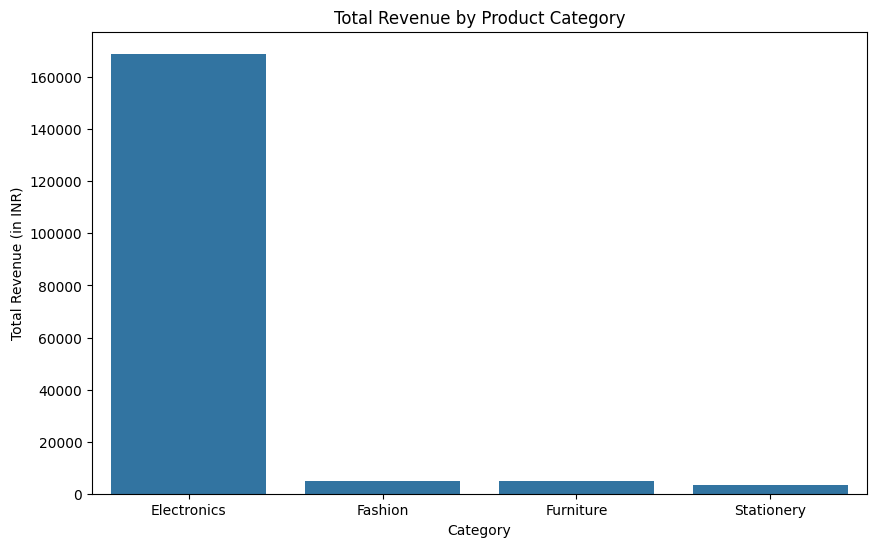

In [17]:
category_revenue_df = spark.sql("""
    SELECT p.category, SUM(o.quantity * p.price) as total_revenue
    FROM orders o
    JOIN products p ON o.product_id = p.product_id
    GROUP BY p.category
    ORDER BY total_revenue DESC
""")

category_revenue_pd = category_revenue_df.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="category", y="total_revenue", data=category_revenue_pd)
plt.title("Total Revenue by Product Category")
plt.xlabel("Category")
plt.ylabel("Total Revenue (in INR)")
plt.show()

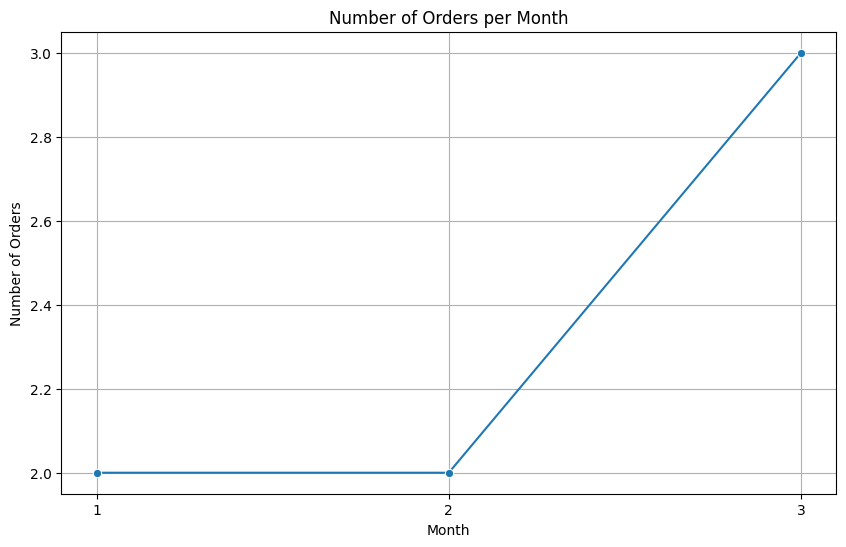

In [18]:
orders_per_month_df = orders_df.withColumn("order_month", month(col("order_date"))) \
    .groupBy("order_month") \
    .agg(count("order_id").alias("num_orders")) \
    .orderBy("order_month")

orders_per_month_pd = orders_per_month_df.toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(x="order_month", y="num_orders", data=orders_per_month_pd, marker='o')
plt.title("Number of Orders per Month")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.xticks(ticks=orders_per_month_pd['order_month'].unique())
plt.grid(True)
plt.show()

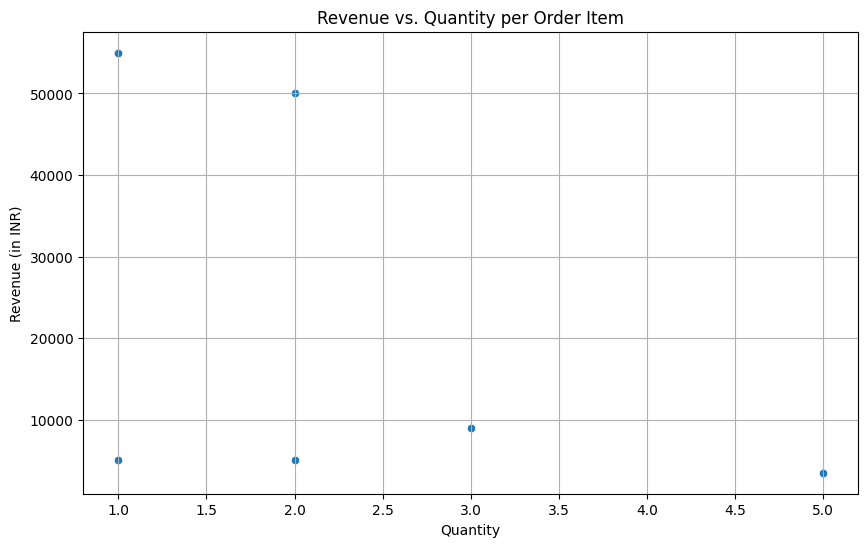

In [19]:
revenue_vs_quantity_df = revenue_df.withColumn("revenue", col("quantity") * col("price")) \
                                   .select("quantity", "revenue")

revenue_vs_quantity_pd = revenue_vs_quantity_df.toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="quantity", y="revenue", data=revenue_vs_quantity_pd)
plt.title("Revenue vs. Quantity per Order Item")
plt.xlabel("Quantity")
plt.ylabel("Revenue (in INR)")
plt.grid(True)
plt.show()